In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import perf_counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, make_scorer, recall_score, classification_report
import xgboost as xgb

In [ ]:
with open('TrainData/train.pkl', 'rb') as f:
    train = pickle.load(f)

train.head()

,CustomerID,ReportedFraud,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,PolicyCombinedLimit,PolicySingleLimit,TimeDelta
0,20065,0,0,1,2,3,6,3,360,19,...,577,1,3,11,18,-0.834616,-0.636247,-0.151765,-0.290132,0.469348
1,37589,0,2,2,1,0,1,2,604,14,...,29,0,2,13,14,1.021569,0.893521,-1.081375,-0.983964,0.218107
2,24312,0,0,2,0,0,2,1,490,21,...,692,0,6,6,8,-0.834616,0.893521,1.397586,1.444450,0.226454
3,5493,1,0,2,0,0,4,3,369,12,...,809,0,1,3,8,0.880455,-1.116315,-1.081375,-0.983964,1.509788
4,7704,1,0,2,0,3,1,5,325,3,...,160,1,5,11,5,-0.834616,0.893521,-0.151765,-0.290132,0.053673


In [ ]:
train = train.drop(['CustomerID', 'InsuredZipCode'], axis=1)
train.head()

,ReportedFraud,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,...,InsuredAge,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,PolicyCombinedLimit,PolicySingleLimit,TimeDelta
0,0,0,1,2,3,6,3,360,19,2,...,2.399207,1,3,11,18,-0.834616,-0.636247,-0.151765,-0.290132,0.469348
1,0,2,2,1,0,1,2,604,14,0,...,-0.602204,0,2,13,14,1.021569,0.893521,-1.081375,-0.983964,0.218107
2,0,0,2,0,0,2,1,490,21,2,...,1.648854,0,6,6,8,-0.834616,0.893521,1.397586,1.444450,0.226454
3,1,0,2,0,0,4,3,369,12,2,...,-1.727734,0,1,3,8,0.880455,-1.116315,-1.081375,-0.983964,1.509788
4,1,0,2,0,3,1,5,325,3,2,...,-1.477616,1,5,11,5,-0.834616,0.893521,-0.151765,-0.290132,0.053673


In [ ]:
X = train.drop(['ReportedFraud'], axis=1)
y = train['ReportedFraud']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
with open('models/rf_regularized.pkl', 'rb') as f:
    rf = pickle.load(f)

with open('models/ada_boost.pkl', 'rb') as f:
    ada = pickle.load(f)

with open('models/xgbc_model.pkl', 'rb') as f:
    xgbc = pickle.load(f)

In [ ]:
rf

RandomForestClassifier(max_depth=30, max_features=None, min_samples_leaf=2,
                       min_samples_split=30, n_estimators=400, n_jobs=-1)

In [ ]:
ada

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.08, n_estimators=350)

In [ ]:
xgbc

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1200, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [22]:
recall_1 = make_scorer(recall_score, pos_label=1)

In [23]:
voting_clf = VotingClassifier(
    estimators=[('xgbc', xgbc), ('rf', rf), ('ada', ada)],
    voting='soft', verbose=1
)

start = perf_counter()
scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring=recall_1)
end = perf_counter()
print(f'Elapsed time: {end - start} seconds')
print(f'Cross validation scores: {scores}')
print(f'Mean cross validation score: {scores.mean()}')

[Voting] ..................... (1 of 3) Processing xgbc, total=  25.9s
[Voting] ....................... (2 of 3) Processing rf, total=  32.4s
[Voting] ...................... (3 of 3) Processing ada, total=  47.1s
[Voting] ..................... (1 of 3) Processing xgbc, total=  27.0s
[Voting] ....................... (2 of 3) Processing rf, total=  34.1s
[Voting] ...................... (3 of 3) Processing ada, total=  45.7s
[Voting] ..................... (1 of 3) Processing xgbc, total=  26.3s
[Voting] ....................... (2 of 3) Processing rf, total=  32.8s
[Voting] ...................... (3 of 3) Processing ada, total=  44.5s
[Voting] ..................... (1 of 3) Processing xgbc, total=  26.4s
[Voting] ....................... (2 of 3) Processing rf, total=  33.6s
[Voting] ...................... (3 of 3) Processing ada, total=  45.0s
[Voting] ..................... (1 of 3) Processing xgbc, total=  26.3s
[Voting] ....................... (2 of 3) Processing rf, total=  33.4s
[Votin

In [25]:
start = perf_counter()
voting_clf.fit(X_train, y_train)
end = perf_counter()
print(f'Elapsed time: {end - start} seconds')

[Voting] ..................... (1 of 3) Processing xgbc, total=  33.7s
[Voting] ....................... (2 of 3) Processing rf, total=  52.4s
[Voting] ...................... (3 of 3) Processing ada, total=  59.7s
Elapsed time: 145.7700473 seconds


In [26]:
print('Train Report\n', classification_report(y_train, voting_clf.predict(X_train)))
print('Test Report\n', classification_report(y_test, voting_clf.predict(X_test)))

Train Report
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     16845
           1       0.96      0.86      0.91      6223

    accuracy                           0.95     23068
   macro avg       0.95      0.92      0.94     23068
weighted avg       0.95      0.95      0.95     23068

Test Report
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      4206
           1       0.93      0.83      0.88      1562

    accuracy                           0.94      5768
   macro avg       0.94      0.91      0.92      5768
weighted avg       0.94      0.94      0.94      5768



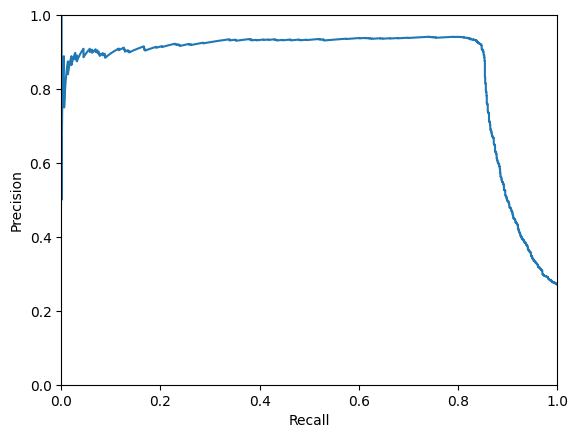

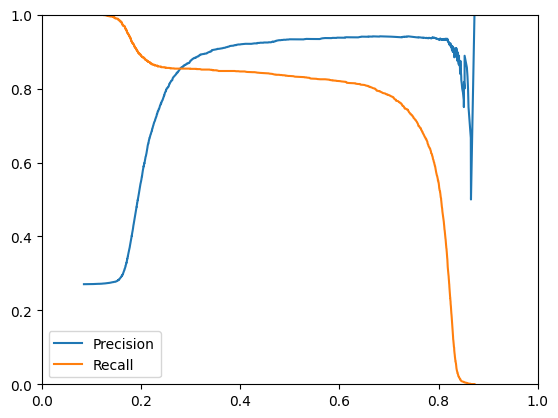

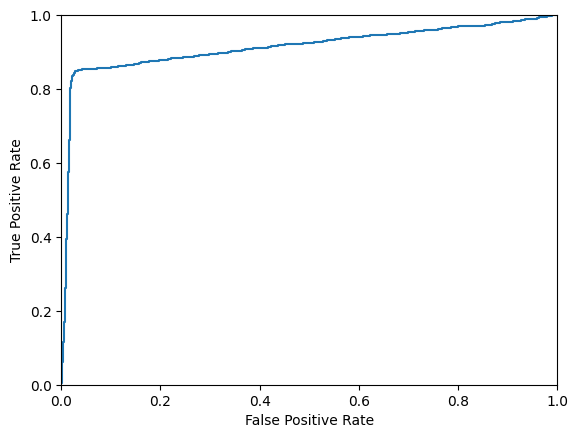

In [19]:
precision, recall, threshold = precision_recall_curve(y_test, voting_clf.predict_proba(X_test)[:, 1])
plt.plot(recall, precision) 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], label='Recall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

fpr, tpr, threshold = roc_curve(y_test, voting_clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [27]:
voting_clf_hard = VotingClassifier(
    estimators=[('xgbc', xgbc), ('rf', rf), ('ada', ada)],
    voting='hard', verbose=1
)

start = perf_counter()
scores = cross_val_score(voting_clf_hard, X_train, y_train, cv=5, scoring=recall_1)
end = perf_counter()
print(f'Elapsed time: {end - start} seconds')
print(f'Cross validation scores: {scores}')
print(f'Mean cross validation score: {scores.mean()}')

[Voting] ..................... (1 of 3) Processing xgbc, total=  27.8s
[Voting] ....................... (2 of 3) Processing rf, total=  34.8s
[Voting] ...................... (3 of 3) Processing ada, total=  48.4s
[Voting] ..................... (1 of 3) Processing xgbc, total=  25.4s
[Voting] ....................... (2 of 3) Processing rf, total=  32.7s
[Voting] ...................... (3 of 3) Processing ada, total=  44.5s
[Voting] ..................... (1 of 3) Processing xgbc, total=  25.6s
[Voting] ....................... (2 of 3) Processing rf, total=  31.5s
[Voting] ...................... (3 of 3) Processing ada, total=  43.5s
[Voting] ..................... (1 of 3) Processing xgbc, total=  24.8s
[Voting] ....................... (2 of 3) Processing rf, total=  33.5s
[Voting] ...................... (3 of 3) Processing ada, total=  43.9s
[Voting] ..................... (1 of 3) Processing xgbc, total=  25.0s
[Voting] ....................... (2 of 3) Processing rf, total=  33.4s
[Votin

In [29]:
start = perf_counter()
voting_clf_hard.fit(X_train, y_train)
end = perf_counter()

[Voting] ..................... (1 of 3) Processing xgbc, total=  33.4s
[Voting] ....................... (2 of 3) Processing rf, total=  44.2s
[Voting] ...................... (3 of 3) Processing ada, total=  56.3s


In [30]:
print('Train Report\n', classification_report(y_train, voting_clf_hard.predict(X_train)))
print('Test Report\n', classification_report(y_test, voting_clf_hard.predict(X_test)))

Train Report
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     16845
           1       0.95      0.86      0.90      6223

    accuracy                           0.95     23068
   macro avg       0.95      0.92      0.93     23068
weighted avg       0.95      0.95      0.95     23068

Test Report
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      4206
           1       0.93      0.83      0.88      1562

    accuracy                           0.94      5768
   macro avg       0.94      0.91      0.92      5768
weighted avg       0.94      0.94      0.94      5768



In [37]:

voting_clf_weak = VotingClassifier(
    estimators=[('rf',RandomForestClassifier()), ('ada', AdaBoostClassifier()), ('xgb',xgb.XGBClassifier())],
    voting='soft', verbose=1
)

start = perf_counter()
scores = cross_val_score(voting_clf_weak, X_train, y_train, cv=5, scoring=recall_1)
end = perf_counter()
print(f'Elapsed time: {end - start} seconds')
print(f'Cross validation scores: {scores}')
print(f'Mean cross validation score: {scores.mean()}')

[Voting] ....................... (1 of 3) Processing rf, total=   4.8s
[Voting] ...................... (2 of 3) Processing ada, total=   2.0s
[Voting] ...................... (3 of 3) Processing xgb, total=   4.3s
[Voting] ....................... (1 of 3) Processing rf, total=   4.6s
[Voting] ...................... (2 of 3) Processing ada, total=   1.9s
[Voting] ...................... (3 of 3) Processing xgb, total=   4.3s
[Voting] ....................... (1 of 3) Processing rf, total=   4.6s
[Voting] ...................... (2 of 3) Processing ada, total=   1.9s
[Voting] ...................... (3 of 3) Processing xgb, total=   4.3s
[Voting] ....................... (1 of 3) Processing rf, total=   4.6s
[Voting] ...................... (2 of 3) Processing ada, total=   1.9s
[Voting] ...................... (3 of 3) Processing xgb, total=   4.3s
[Voting] ....................... (1 of 3) Processing rf, total=   4.6s
[Voting] ...................... (2 of 3) Processing ada, total=   1.9s
[Votin

In [38]:
voting_clf_weak.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing rf, total=   6.0s
[Voting] ...................... (2 of 3) Processing ada, total=   2.3s
[Voting] ...................... (3 of 3) Processing xgb, total=   5.4s


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('ada', AdaBoostClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 verbose=1, voting='soft')

In [39]:
print('Train Report\n', classification_report(y_train, voting_clf_weak.predict(X_train)))
print('Test Report\n', classification_report(y_test, voting_clf_weak.predict(X_test)))

Train Report
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     16845
           1       0.99      0.93      0.96      6223

    accuracy                           0.98     23068
   macro avg       0.98      0.96      0.97     23068
weighted avg       0.98      0.98      0.98     23068

Test Report
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      4206
           1       0.93      0.84      0.88      1562

    accuracy                           0.94      5768
   macro avg       0.93      0.91      0.92      5768
weighted avg       0.94      0.94      0.94      5768



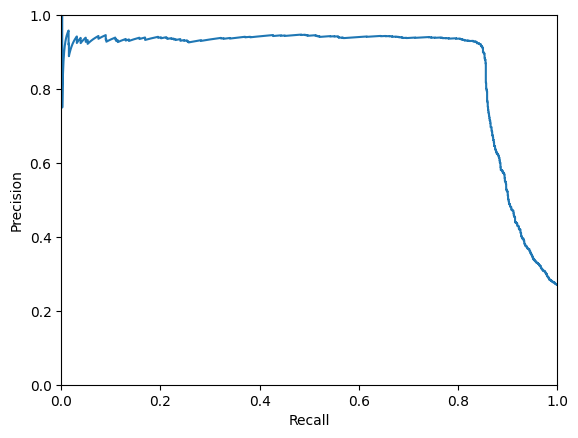

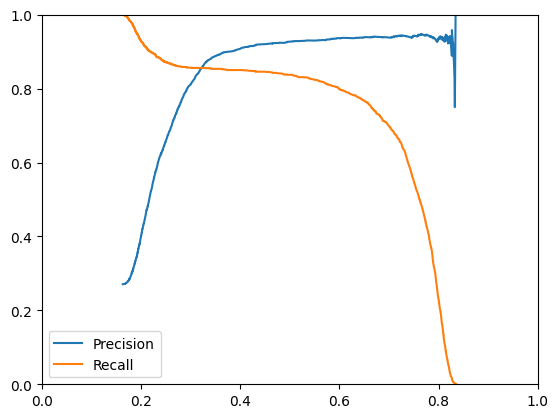

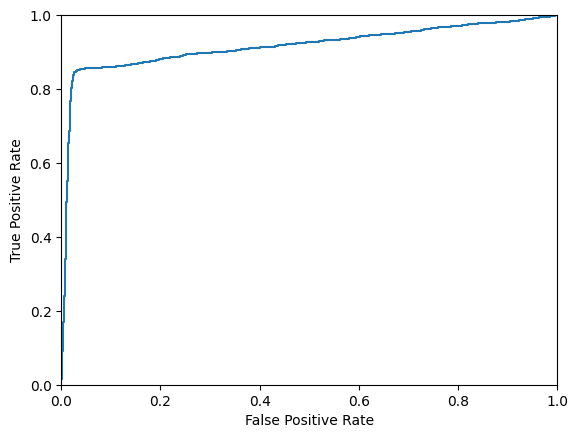

In [40]:
precision, recall, threshold = precision_recall_curve(y_test, voting_clf_weak.predict_proba(X_test)[:, 1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], label='Recall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

fpr, tpr, threshold = roc_curve(y_test, voting_clf_weak.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


In [41]:
with open('models/voting_clf.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)

with open('models/voting_clf_weak.pkl', 'wb') as f:
    pickle.dump(voting_clf_weak, f)